In [1]:
# ----- 1. Import data
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re
from textblob import TextBlob
import string
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tweepy
import os
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)
pd.set_option('display.width', 100000)

In [2]:
df= pd.read_csv("/Users/sooyoungkim/Desktop/dta_inc/dta/home_workouts.csv")

In [3]:
# ----- 2. Clean text

#lowercase
df['original_text'] = df['original_text'].str.lower()
#remove numbers
df['original_text'] = df['original_text'].str.replace('\d+', '')
#remove punctuation
df['original_text'] = df['original_text'].str.replace('[^\w\s]','')
#remove whitespace
df['original_text'] = df['original_text'].str.strip()
# Get rid of weird puncutation
df['original_text'] = df['original_text'].apply(lambda x: x.replace('like', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('ive', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('want', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('rt', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('get', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('.', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('\n', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('?', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('!', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('""', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace(';', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('#', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('&amp', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('Ä¶', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('Äì', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('https', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('RT', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('l', ''))
df['original_text'] = df['original_text'].apply(lambda x: x.replace('fu', ''))

#remove stopwords
from nltk.corpus import stopwords
cached_stop_words = stopwords.words('english')
df['cleaned'] = [' '.join([w for w in x.lower().split() if w not in cached_stop_words]) 
    for x in df['original_text'].tolist()]

array = df['cleaned'].str.split(' ', expand = True).stack().value_counts()
d = {'word': array.index, 'frequency':array}
df2 = pd.DataFrame(data = d)

<Figure size 864x720 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

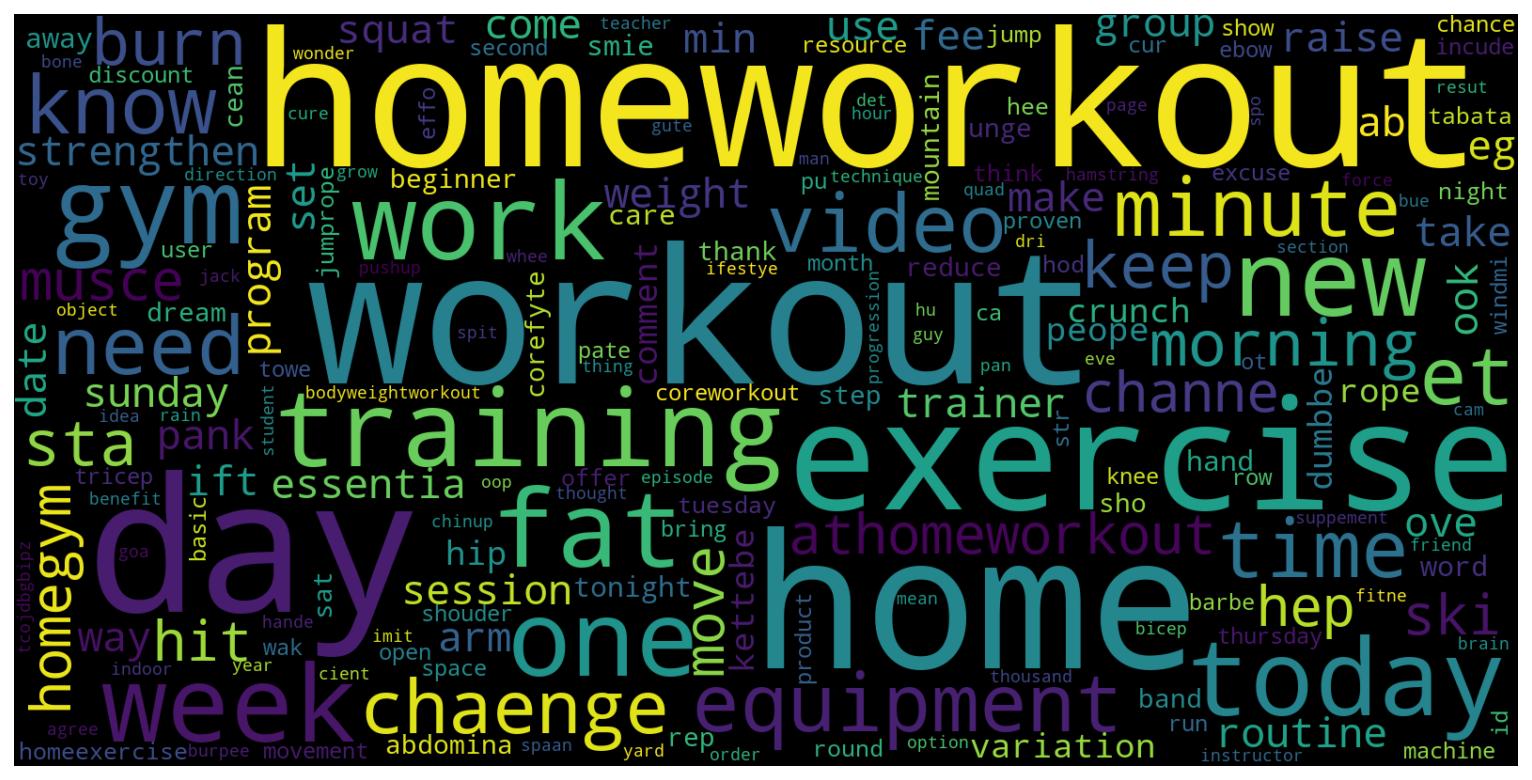

In [4]:
# ----- 3. Word cloud
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

test_string = []
for t in df2.word:
    test_string.append(t)
test_string = pd.Series(test_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(test_string)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

#plt.savefig('/Users/sooyoungkim/Desktop/dta_inc/wordcloud.png', dpi=100)
plt.show()

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Home Workout Word Count')

Text(0.5, 0, 'Words')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

Text(0, 0.5, 'Frequency')

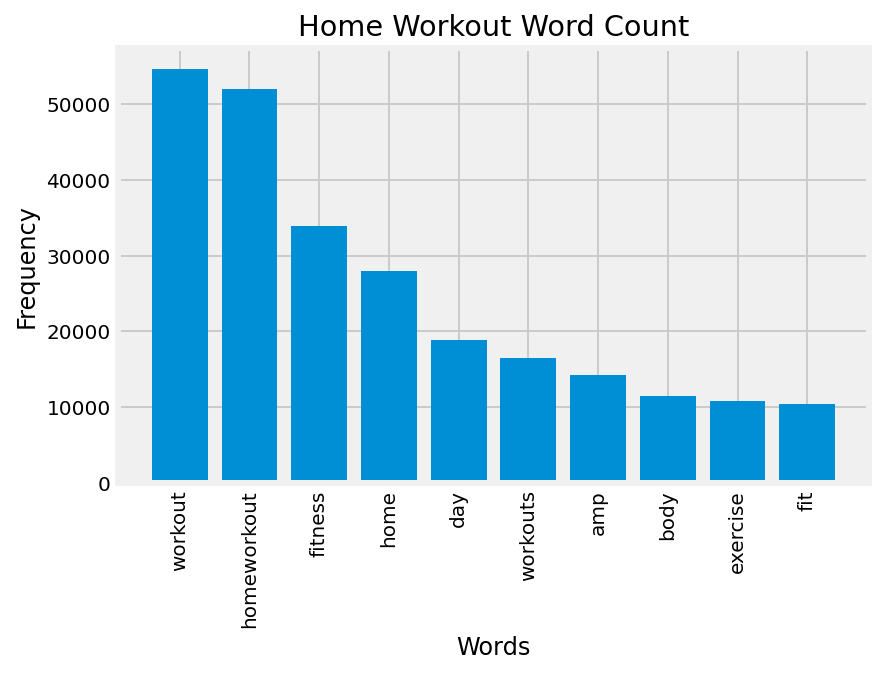

In [5]:
# Create bars
df2_count = df2.drop(df2[(df2.frequency <= 10000)].index)
df2_count = df2_count .dropna(subset=['frequency'])
 
# Create names on the x-axis
plt.bar(df2_count['word'], df2_count['frequency'])
plt.title("Home Workout Word Count")
plt.xlabel("Words")
plt.xticks(rotation = 90)
plt.ylabel("Frequency")

#plt.savefig('/Users/sooyoungkim/Desktop/dta_inc/count.png')
plt.show()

In [6]:
# ----- 3. Sentiment
df["polarity"] = pd.to_numeric(df.polarity, errors='coerce')
df["subjectivity"] = pd.to_numeric(df.polarity, errors='coerce')

# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df['Analysis'] = df['polarity'].apply(getAnalysis)

Text(0.5, 1.0, 'Sentiment Analysis')

Text(0.5, 0, 'Sentiment')

Text(0, 0.5, 'Counts')

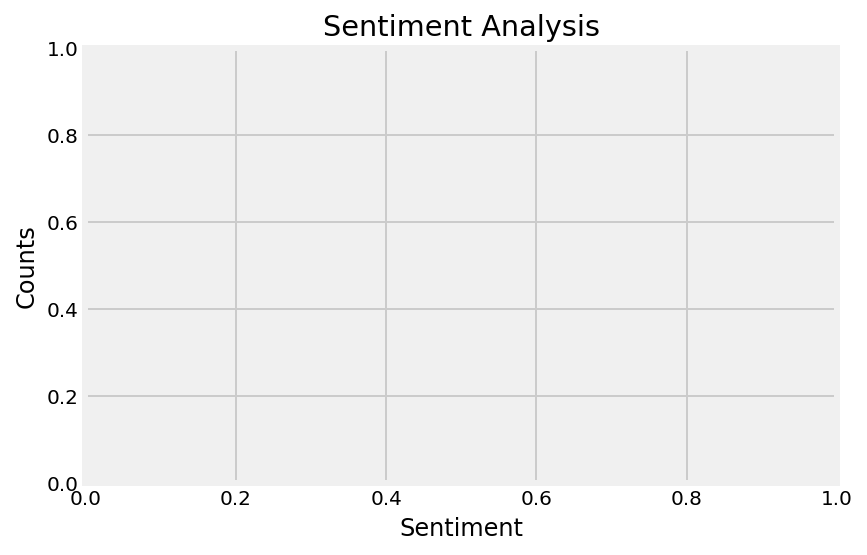

In [7]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

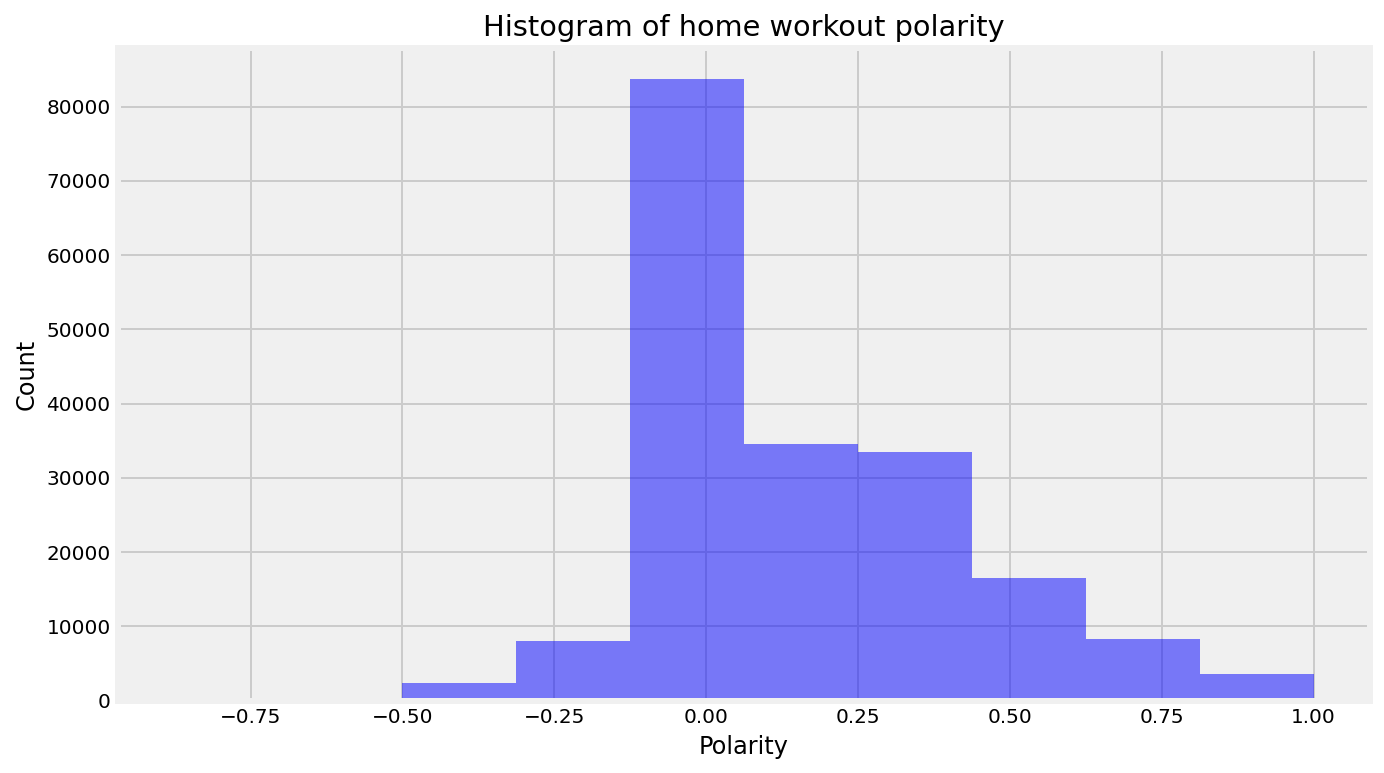

In [32]:
num_bins = 10
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of home workout polarity')
#plt.savefig('/Users/sooyoungkim/Desktop/dta_inc/hist.png')
plt.show();

In [ ]:
# ----- 4. Test/training date
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

data_positive = df[df['Analysis']== "Positive"]
data_neutral = df[df['Analysis']== "Neutral"]
data_negative = df[df['Analysis']== "Negative"]

# Create balanced dataset
sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['cleaned'].values[:sample_size], 
                           data_negative['cleaned'].values[:sample_size]), axis=0) 
labels = [1]*sample_size + [0]*sample_size

import re
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    return text.strip()
data = [preprocess_text(t) for t in raw_data]

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [25]:
# ----- 4. Test/training date
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

data_positive = df[df['Analysis']== "Positive"]
data_negative = df[df['Analysis']== "Negative"]


# Create balanced dataset
sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['cleaned'].values[:sample_size], 
                           data_negative['cleaned'].values[:sample_size]), axis=0) 
labels = [1]*sample_size + [0]*sample_size

import re
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    return text.strip()
data = [preprocess_text(t) for t in raw_data]

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring="f1_macro")
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                           

              precision    recall  f1-score   support

           0     0.9975    1.0000    0.9987      3953
           1     1.0000    0.9975    0.9987      3945

    accuracy                         0.9987      7898
   macro avg     0.9987    0.9987    0.9987      7898
weighted avg     0.9987    0.9987    0.9987      7898



In [28]:
data_positive = df[df['Analysis']== "Positive"]
data_neutral = df[df['Analysis']== "Neutral"]
data_negative = df[df['Analysis']== "Negative"]


# Create balanced dataset
sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['cleaned'].values[:sample_size],
                           data_neutral['cleaned'].values[:sample_size],
                           data_negative['cleaned'].values[:sample_size]), axis=0) 
labels = [1]*sample_size + [2]*sample_size + [3]*sample_size

import re
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    return text.strip()
data = [preprocess_text(t) for t in raw_data]

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring="f1_macro")
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                           

              precision    recall  f1-score   support

           1     1.0000    0.9964    0.9982      3934
           2     1.0000    1.0000    1.0000      3972
           3     0.9965    1.0000    0.9982      3941

    accuracy                         0.9988     11847
   macro avg     0.9988    0.9988    0.9988     11847
weighted avg     0.9988    0.9988    0.9988     11847

